In [18]:
import numpy as np
import torch
import os
from DS3Dplus.ds3d_utils import ImModelBase, ImModelTraining, Sampling, calc_jaccard_rmse, Volume2XYZ
import matplotlib.pyplot as plt
import matplotlib

import pickle
from skimage import io
from torch.nn.functional import interpolate
import time
from datetime import datetime
import csv
from numpy import pi

from torch import nn

# matplotlib.use("TkAgg")  # uncomment this if you want pop out window

In [19]:
# prepare the trained model
path_save = os.getcwd() + r'\training_results'
net_file = 'net_06-06_15-47.pt'
fit_file = 'fit_06-06_15-47.pickle'
param_dict_path = r'D:\Dafei\AutoDS3D\training_data\laminB1_us1\param.pickle'

exp_imgs_path = r'.\dataset2\laminB1_dense_dh_br'

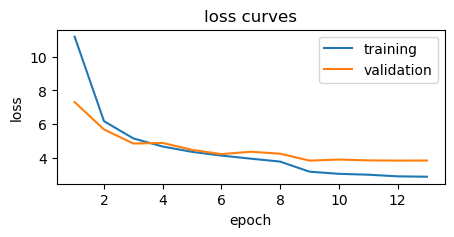

In [20]:
with open(os.path.join(path_save, fit_file), 'rb') as handle:
    fit_result = pickle.load(handle)
num_epochs = fit_result.num_epochs
train_loss = fit_result.train_loss
test_loss = fit_result.test_loss

num_epochs = len(train_loss)
plt.figure(figsize=(5, 2))
plt.plot(np.arange(1, num_epochs+1), train_loss, label='training')
plt.plot(np.arange(1, num_epochs+1), test_loss, label='validation')
plt.legend()
plt.title('loss curves')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()


In [21]:
with open(param_dict_path, 'rb') as handle:
    param_dict = pickle.load(handle) 
    
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
param_dict['device'] = device
param_dict['blob_r'] = 2
param_dict['threshold'] = 40  # 80-40

In [22]:
checkpoint = torch.load(os.path.join(path_save, net_file), map_location=device)
net = checkpoint['net']
net.load_state_dict(checkpoint['state_dict'])  

<All keys matched successfully>

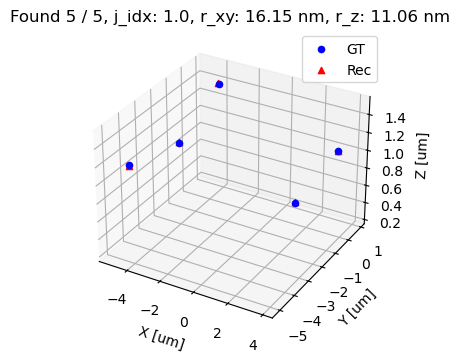

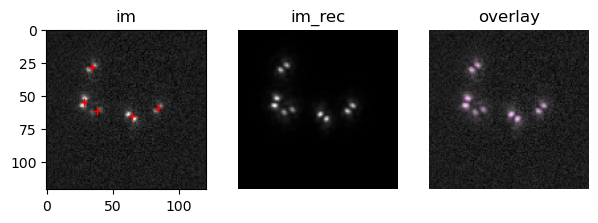

In [23]:
# simulation
np.random.seed(22)
torch.manual_seed(22)


model = ImModelTraining(param_dict)
sampling = Sampling(param_dict)
volume2xyz = Volume2XYZ(param_dict)

xyzps, _, _ = sampling.xyzp_batch()
im = model(torch.from_numpy(xyzps).to(device)).cpu().numpy().astype(np.float32)
if param_dict['project_01']:
    im = ((im - im.min()) / (im.max() - im.min())).astype(np.float32)
    
with torch.no_grad():
    net.eval()
    vol = net(torch.from_numpy(im[np.newaxis, np.newaxis, :, :]).to(device))
xyz_rec, conf_rec = volume2xyz(vol)  # xy localizations relative to the FOV center


if xyz_rec is not None:
    xyz_gt = xyzps[:, :-1]
    jaccard_index, RMSE_xy, RMSE_z, _ = calc_jaccard_rmse(xyz_gt, xyz_rec, 0.1)   # set the radius
    jaccard_index, RMSE_xy, RMSE_z = np.round(jaccard_index, decimals=2), np.round(RMSE_xy*1000, decimals=2), np.round(RMSE_z*1000, decimals=2)
    
    # plot 1: emitters in 3d space
    fig = plt.figure(figsize=(5, 4))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(xyz_gt[:, 0], xyz_gt[:, 1], xyz_gt[:, 2], c='b', marker='o', label='GT', depthshade=False)
    ax.scatter(xyz_rec[:, 0], xyz_rec[:, 1], xyz_rec[:, 2], c='r', marker='^', label='Rec', depthshade=False)
    ax.set_xlabel('X [um]')
    ax.set_ylabel('Y [um]')
    ax.set_zlabel('Z [um]')
    if RMSE_xy is not None:
        plt.title(f'Found {xyz_rec.shape[0]} / {xyz_gt.shape[0]}, j_idx: {jaccard_index}, r_xy: {RMSE_xy} nm, r_z: {RMSE_z} nm')
    else:
        plt.title(f'Found {xyz_rec.shape[0]} emitters out of {xyz_gt.shape[0]}')
    plt.legend()
    
    
    nphotons_rec = (param_dict['Nsig_range'][0]+param_dict['Nsig_range'][1])/2 * np.ones(xyz_rec.shape[0])
    psfs_rec = model.get_psfs(torch.from_numpy(np.c_[xyz_rec, nphotons_rec]).to(device)).cpu().numpy()
    im_rec = np.sum(psfs_rec, axis=0)
    im_rec = (im_rec-im_rec.min())/(im_rec.max()-im_rec.min())
    im = (im-im.min())/(im.max()-im.min())
    
    ps_xy = param_dict['vs_xy']*param_dict['us_factor']
    h, w = im.shape
    ch, cw = (h-1)/2, (w-1)/2
    
    fig = plt.figure(figsize=(7, 3))
    plt.subplot(1, 3, 1)
    plt.imshow(im, cmap='gray')
    plt.plot(xyz_rec[:, 0] / ps_xy + cw, xyz_rec[:, 1] / ps_xy + ch, 'r+')
    plt.title('im')
    

    plt.subplot(1, 3, 2)
    plt.imshow(im_rec, cmap='gray')
    plt.title('im_rec')
    plt.axis('off')

    mask = np.max(psfs_rec, axis=0)
    mask = (mask-mask.min())/(mask.max()-mask.min())
    mask = 1-mask
    transparency = 0.2+mask*0.8
    im_overlay = np.stack((im, im, im, transparency), axis=-1)
    im_overlay[:, :, 1] = im_overlay[:, :, 1] * mask
    plt.subplot(1, 3, 3)
    plt.imshow(im_overlay)
    plt.title('overlay')
    plt.axis('off')
    plt.show()
    
else:
    print('xyz_rec is empty.')
 



In [24]:
img_names = sorted(os.listdir(exp_imgs_path))
num_imgs = len(img_names)
print(f'the number of images: {num_imgs}')

the number of images: 100


In [25]:
### specify post-processing parameters for experimental images
param_dict['blob_r'] = 2
param_dict['threshold'] = 60  # 80-40

131


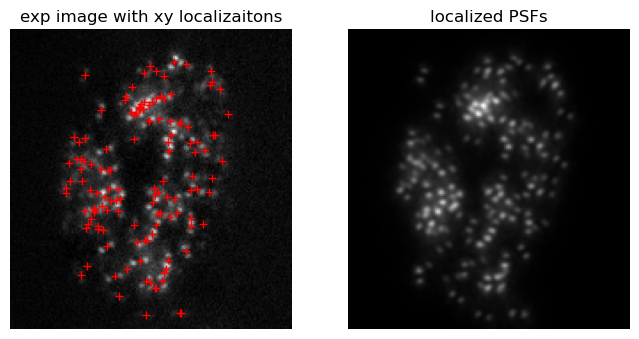

In [26]:
# try the first image
im_idx = 0

volume2xyz = Volume2XYZ(param_dict)
im_path = os.path.join(exp_imgs_path, img_names[im_idx])
im = io.imread(im_path).astype(np.float32)
if param_dict['project_01']:
    im = ((im - im.min()) / (im.max() - im.min())).astype(np.float32)
with torch.no_grad():
    net.eval()
    vol = net(torch.from_numpy(im[np.newaxis, np.newaxis, :, :]).to(device))
    xyz_rec, conf_rec = volume2xyz(vol)

H, W = im.shape
param_dict['H'], param_dict['W'] = H, W
model = ImModelTraining(param_dict)    
if H > param_dict['phase_mask'].shape[0] or W > param_dict['phase_mask'].shape[1]:
    sf = max(H // param_dict['phase_mask'].shape[0] + 1, W // param_dict['phase_mask'].shape[1] + 1)
    param_dict['ps_BFP'] /= sf
    phase_mask = param_dict['phase_mask']
    HW = np.floor(param_dict['f_4f'] * param_dict['lamda'] / (
                param_dict['ps_camera'] * param_dict['ps_BFP']))  # simulation size
    HW = int(HW + 1 - (HW % 2))  # make it odd

    phase_mask = interpolate(torch.tensor(phase_mask).unsqueeze(0).unsqueeze(1), size=(HW, HW))
    param_dict['phase_mask'] = phase_mask[0, 0].numpy()
    model = ImModelTraining(param_dict)
    
photons_rec = (param_dict['Nsig_range'][0]+param_dict['Nsig_range'][1])/2
nphotons_rec = photons_rec * np.ones(xyz_rec.shape[0])
psfs_rec = model.get_psfs(torch.from_numpy(np.c_[xyz_rec, nphotons_rec]).to(device)).cpu().numpy()
im_rec = np.sum(psfs_rec, axis=0)

print(xyz_rec.shape[0])
# plot
ps_xy = param_dict['vs_xy']*param_dict['us_factor']
h, w = im.shape
ch, cw = (h-1)/2, (w-1)/2

plt.figure(figsize=(8, 5))
plt.subplot(121)
imfig = plt.imshow(im, cmap='gray')
plt.plot(xyz_rec[:, 0] / ps_xy + cw, xyz_rec[:, 1] / ps_xy + ch, 'r+')
plt.title('exp image with xy localizaitons')
plt.axis('off')
plt.subplot(122)
plt.imshow(im_rec, cmap='gray')
plt.title('localized PSFs')
plt.axis('off')
plt.show()

In [27]:
# process all the images

# time the entire dataset analysis
tall_start = time.time()
# needed pixel-size for plotting if only few images are in the folder
ps_xy = param_dict['ps_xy'] # FOV size, camera pixel size/magnification
# process all experimental images
net.eval()
results = np.array(['frame', 'x [nm]', 'y [nm]', 'z [nm]', 'intensity [au]'])
with torch.no_grad():
    for im_ind, im_name in enumerate(img_names):
        # time each frame
        tfrm_start = time.time()

        im = io.imread(os.path.join(exp_imgs_path, im_name)).astype(np.float32)
        if param_dict['project_01']:
            im = ((im - im.min()) / (im.max() - im.min())).astype(np.float32)
        vol = net(torch.from_numpy(im[np.newaxis, np.newaxis, :, :]).to(device))
        xyz_rec, conf_rec = volume2xyz(vol)

        # time it takes to analyze a single frame
        tfrm_end = time.time() - tfrm_start

        # if this is the first image, get the dimensions and the relevant center for plotting
        if im_ind == 0:
            H, W = im.shape
            ch, cw = H / 2, W / 2

        # if prediction is empty then set number fo found emitters to 0
        # otherwise generate the frame column and append results for saving
        if xyz_rec is None:
            nemitters = 0
        else:
            nemitters = xyz_rec.shape[0]
            frm_rec = (im_ind + 1) * np.ones(nemitters)
            xnm = (xyz_rec[:, 0] + cw * ps_xy) * 1000
            ynm = (xyz_rec[:, 1] + ch * ps_xy) * 1000
            znm = (xyz_rec[:, 2]) * 1000
            xyz_save = np.c_[xnm, ynm, znm]
            
            results = np.vstack((results, np.column_stack((frm_rec, xyz_save, conf_rec))))
            if im_ind % (num_imgs // 10) == 0:
                print('Processed Image [%d/%d]' % (im_ind + 1, num_imgs))
                # print status
                print('Single frame complete in {:.6f}s, found {:d} emitters'.format(tfrm_end, nemitters))

# print the time it took for the entire analysis
tall_end = time.time() - tall_start
print('=' * 50)
print('Analysis complete in {:.0f}h {:.0f}m {:.0f}s'.format(
    tall_end // 3600, np.floor((tall_end / 3600 - tall_end // 3600) * 60), tall_end % 60))
print('=' * 50)

time_now = datetime.today().strftime('%m-%d_%H-%M')

file_name = os.path.join(os.getcwd(), 'localizations_' + time_now + '.csv')
with open(file_name, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(results.tolist())
print(f'{file_name} is saved.')

Processed Image [1/100]
Single frame complete in 0.025669s, found 131 emitters
Processed Image [11/100]
Single frame complete in 0.016000s, found 110 emitters
Processed Image [21/100]
Single frame complete in 0.015625s, found 118 emitters
Processed Image [31/100]
Single frame complete in 0.015650s, found 112 emitters
Processed Image [41/100]
Single frame complete in 0.015626s, found 92 emitters
Processed Image [51/100]
Single frame complete in 0.015609s, found 102 emitters
Processed Image [61/100]
Single frame complete in 0.015660s, found 151 emitters
Processed Image [71/100]
Single frame complete in 0.015625s, found 119 emitters
Processed Image [81/100]
Single frame complete in 0.015600s, found 115 emitters
Processed Image [91/100]
Single frame complete in 0.016751s, found 117 emitters
Analysis complete in 0h 0m 2s
C:\Users\dafei.xiao\Desktop\autods3d\localizations_07-26_11-12.csv is saved.
